Homotopy Continuation/Certfication file. This file contains all different versions of homotopy continuation as described in the thesis, defined as functions. It also contains functions for certification and coefficient-parameter homotopies.

First, we import the necessary packages including the file containing the data for our examples.

In [4]:
import random
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import Data_for_Examples as E

We define all functions that are used repeatedly. This does not include functions such as Euler's and Newton's method, since we adjust these along the way.

In [5]:
#Total degree start system of polynomial system F:
def Total_degree_start_system(variables,F):
    # Calculate total degree for each polynomial        
    total_degrees = []
    for poly in F:
        total_degree = max(sum(mon) for mon in poly.as_poly(variables).monoms())
        total_degrees.append(total_degree)
        #Find starting polynomial system G of total degree:
    G=np.array([])
    for i in range(len(variables[:-1])):
        G=np.append(G,variables[i]**total_degrees[i]-1)
    return G,total_degrees

First version of Homotopy continuation, corresponding to Algorithm 3.3.1:

Solution 1: [[1.41421356+6.34637945e-11j]
 [1.41421356+3.53383815e-10j]]
Solution 2: Path is going to infinity
Solution 3: Path is going to infinity
Solution 4: [[-6.34637945e-11+1.41421356j]
 [ 8.26889827e-09-1.41421356j]]
Solution 5: Path is going to infinity
Solution 6: [[-1.41421356-6.34637945e-11j]
 [-1.41421356-3.53383815e-10j]]
Solution 7: [[ 6.34637945e-11-1.41421356j]
 [-8.26889827e-09+1.41421356j]]
Solution 8: Path is going to infinity


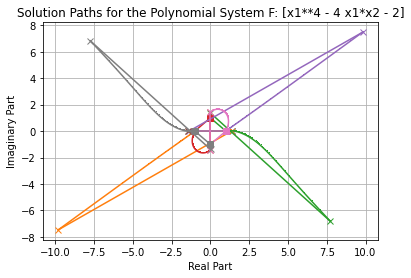

None


In [6]:
#First version of Homotopy Continuation:
def Homotopy_Continuation_1(F,variables,M=100):
    #Total degree start system G along with list of total degrees: 
    G,degrees=Total_degree_start_system(variables,F)
    
    #Set function in array for syntax:
    F=np.array(F)

    #Set stepsize h:
    h=1.0/M

    #Set x for variables that does not include t:
    t=variables[-1]
    x=variables[:-1]

    #Generate a random complex number gamma of modulus 1:
    c_number=complex(random.uniform(-1,1),random.uniform(-1,1))
    gamma=c_number/np.linalg.norm(c_number)

    #This defines our homotopy and the functions generated by the Davidenko equations:
    H=t*F+gamma*(1-t)*G #Homotopy H
    dtH = sp.lambdify(variables,sp.Matrix([H]).diff(t),'numpy') #Derivative of H with respect to t, which can be evaluated at a point
    dxH = sp.lambdify(variables,sp.Matrix([H]).jacobian([x]),'numpy') #Derivatibe of H with respect to x, which can be evaluated at a point
    H_eval=sp.lambdify(variables,H,'numpy') #H, which can be evaluated at a point

    #Define Euler step:
    def euler_method(x_euler,t_euler):
        return x_euler-h * (np.linalg.inv(dxH(*(x_euler[:,0]),t_euler)) @ np.transpose(dtH(*(x_euler[:,0]),t_euler))) #Definition from the Davidenko equations.
    
    #Define Newton step:
    def newton_method(x_newton, t_newton, tol=1e-6,max_iterations=3):
        k=0
        H_newton=np.array(H_eval(*np.append((x_newton[:,0]),[t_newton]))).reshape(-1,1) #Initial value of H
        while any(abs(a) > tol for a in H_newton) and k<max_iterations: #While not convergent, meaning modulus of each entry is large and we have used fewer than "max_iterations" iterations.
            x_newton-= (np.linalg.inv(dxH(*x_newton[:,0], t_newton))@H_newton) #Update solutions
            H_newton=np.array(H_eval(*np.append((x_newton[:,0]),[t_newton]))).reshape(-1,1) #Update H
            k+=1
        return x_newton        
    
    #Define function that constructs a path for each solution between F and G:
    def path_solution(x0_single, max_change=100):
        plot_points=[x0_single] #Keep track of points we want to plot
        j=0
        while j <M:  # Iterate through each step
            x0_prev=np.copy(x0_single) #Save previous point.
            t_j = j*h
            # Predictor step (Euler's method)        
            x_pc = euler_method(x0_single, t_j)
            # Corrector step (Newton's method)
            x0_single = newton_method(x_pc, t_j+h)
            plot_points.append(x0_single) #Keep track of points we want to plot
            
            #If the difference between the current and previous point is too large, path goes to infinity.
            if np.linalg.norm(x0_single-x0_prev) > max_change*1/M:
                return "Path is going to infinity", plot_points    
            j+=1
        return x0_single, plot_points

    #Finding roots of G:
    x0=[]    
    roots_initial=[np.exp(2j * np.pi * np.arange(d) / d) for d in degrees] #Find roots of unity with respect to each of the degrees in the startsystem.
    #We find all combinations of solutions, which is our solutions to the total degree start system.
    for root0 in roots_initial[0]:
        x0.append([root0])
    for roots in roots_initial[1:]:
        np.ndarray.tolist(roots)
        x0=[a+[b] for a in x0 for b in roots] #We construct a list of lists consisting of the solutions of G.

    #Construct path for each of the initial solutions G to target solutions F:
    x_new=[]
    plot_x=[] 
    for x0_sol in x0:
        x0_sol,plot_sol=path_solution(np.array(x0_sol).reshape(-1,1))
        x_new.append(x0_sol)
        plot_x.append(plot_sol)

    #Print solutions
    for i in range(len(x_new)):
        print(f"Solution {i+1}: {x_new[i]}")
    #Plot solution paths:
    fig, ax = plt.subplots()
    for xi_plotlist in plot_x:
        # Extract real and imaginary parts of the solutions
        real_parts = [x.real for x in np.squeeze(xi_plotlist)]
        imag_parts = [x.imag for x in np.squeeze(xi_plotlist)]
        # Plot the path for the current root
        color = next(ax._get_lines.prop_cycler)['color'] #Ensures end points has same color as path
        ax.plot(real_parts, imag_parts, marker=',', linestyle='-',color=color)
        ax.plot(real_parts[0], imag_parts[0], marker='s', linestyle='-',color=color) #Path starts with a square.
        ax.plot(real_parts[-1], imag_parts[-1], marker='x', linestyle='-',color=color) #Path ends in an asterix.
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    ax.set_title(f'Solution Paths for the Polynomial System F: {F}')
    plt.grid(True)
    plt.show()    
print(Homotopy_Continuation_1(*E.Homotopy_1))